## Skipgrams in Keras
### Modified by Darshan Patel

- In this lecture, we will implement Skipgrams in `Keras`.

#### Loading in and preprocessing data
- Load the Alice in Wonderland data in Corpus using Keras utility
- `Keras` has some nice text preprocessing features too!
- Split the text into sentences.
- Use `Keras`' `Tokenizer` to tokenize sentences into words.

In [1]:
!pip install pandas
!pip install numpy
!pip install nltk

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Imports
# Basics
from __future__ import print_function, division
import pandas as pd 
import numpy as np
import random
from IPython.display import SVG
%matplotlib inline

# nltk
from nltk import sent_tokenize

# keras
np.random.seed(13)
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Activation
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot 
from keras.preprocessing.sequence import skipgrams

/Users/darshanpatel/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/darshanpatel/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# We'll use Alice in Wonderland

path = get_file('carrol-alice.txt', origin="http://www.gutenberg.org/files/11/11-0.txt")
corpus = open(path).read()

180224/173595 [===============================] - 0s 2us/step


In [5]:
# Split document into sentences first
corpus = corpus[corpus.index('\n\n')+2:]  # remove header.
sentences = sent_tokenize(corpus)

# Tokenize using Keras
base_filter='!"#$%&()*+,-./:;`<=>?@[\\]^_{|}~\t\n' + "'"
tokenizer = Tokenizer(filters=base_filter)
tokenizer.fit_on_texts(sentences)

# Convert tokenized sentences to sequence format
sequences = tokenizer.texts_to_sequences(sentences)
nb_samples = sum(len(s) for s in corpus)

print(len(sequences), tokenizer.document_count)

1093 1093


In [6]:
# To understand what is happening;

print(sentences[324])  # this is a sentence
print(sequences[324])  # this is the same sentence where words are encoded as numbers.
print(list(tokenizer.word_index[word.lower().replace('.', '')] 
           for word in sentences[324].split()))

The Caterpillar was the first to speak.
[1, 182, 13, 1, 98, 4, 330]
[1, 182, 13, 1, 98, 4, 330]


#### Skipgrams: Generating Input and Output Labels
- Now that we have sentences, and word tokenization, we are in good position to create our training set for skipgrams.
- Now we need to generate our `X_train` and `y_train`

In [7]:
# Let's first see how Keras' skipgrams function works.

couples, labels = skipgrams(sequences[324], len(tokenizer.word_index) + 1,
    window_size=2, negative_samples=0, shuffle=True,
    categorical=False, sampling_table=None)

index_2_word = {val: key for key, val in tokenizer.word_index.items()}

for w1, w2 in couples:
    if w1 == 13:
        print(index_2_word[w1], index_2_word[w2])

was the
was the
was first
was caterpillar


In [8]:
# Function to generate the inputs and outputs for all windows

# Vocab size
vocab_size = len(tokenizer.word_index) + 1
# Dimension to reduce to
dim = 100
window_size = 2


def generate_data(sequences, window_size, vocab_size):
    for seq in sequences:
        X, y = [], []
        couples, _ = skipgrams(
            seq, vocab_size,
            window_size=window_size, negative_samples=0, shuffle=True,
            categorical=False, sampling_table=None)
        if not couples:
            continue
        for in_word, out_word in couples:
            X.append(in_word)
            y.append(np_utils.to_categorical(out_word, vocab_size))
        X, y = np.array(X), np.array(y)
        X = X.reshape(len(X), 1)
        y = y.reshape(len(X), vocab_size)
        yield X, y
        
data_generator = generate_data(sequences, window_size, vocab_size)

### Skipgrams: Creating the Model
- Lastly, we create the (shallow) network!

In [9]:
# Create the Keras model and view it 
skipgram = Sequential()
skipgram.add(Embedding(input_dim=vocab_size, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim,)))
skipgram.add(Dense(input_dim=dim, units=vocab_size, activation='softmax'))
#SVG(model_to_dot(skipgram, show_shapes=True).create(prog='dot', format='svg'))

### Skipgrams: Compiling and Training
- Time to compile and train
- We use crossentropy, common loss for classification

In [13]:
# Compile the Keras Model
from keras.optimizers import SGD
sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9)

skipgram.compile(loss='categorical_crossentropy', optimizer="adadelta")

# Fit the Skipgrams
loss_list = []
for iteration in range(10):
    loss = 0
    for x, y in generate_data(sequences, window_size, vocab_size):
        loss += skipgram.train_on_batch(x, y)
    print('iteration {}, loss is {}'.format(iteration, loss))
    loss_list.append(loss)

iteration 0, loss is 6722.870360851288
iteration 1, loss is 6688.289189577103
iteration 2, loss is 6656.273895025253
iteration 3, loss is 6626.725339412689
iteration 4, loss is 6599.9774005413055
iteration 5, loss is 6575.635527849197
iteration 6, loss is 6553.022658109665
iteration 7, loss is 6531.792238950729
iteration 8, loss is 6511.797105073929
iteration 9, loss is 6492.926450848579


In [18]:
range(1,10)

range(1, 10)

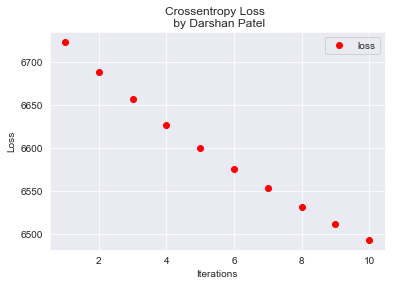

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


plt.plot(range(1,11), loss_list, 'ro', label='loss')
plt.title('Crossentropy Loss \n by Darshan Patel')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Exercise
Above we use the “Stochastic gradient descent optimizer” in keras. Modify its parameter “momentum” to 0.5 and retrain the result. Print the result.

### Skipgrams: Looking at the vectors

To get word_vectors now, we look at the weights of the first layer.

Let's also write functions giving us similarity of two words.

In [26]:
word_vectors = skipgram.get_weights()[0]


from scipy.spatial.distance import cosine


def get_dist(w1, w2):
    i1, i2 = tokenizer.word_index[w1], tokenizer.word_index[w2]
    v1, v2 = word_vectors[i1], word_vectors[i2]
    return cosine(v1, v2)

def get_similarity(w1, w2):
    return 1-get_dist(w1, w2)

def get_most_similar(w1, n=10):
    sims = {word: get_similarity(w1, word) 
            for word in tokenizer.word_index.keys()
            if word != w1}
    sims = pd.Series(sims)
    sims.sort_values(inplace=True, ascending=False)
    return sims.iloc[:n]


print(get_similarity('king', 'queen'))
print('')
print(get_most_similar('queen'))

0.9449026584625244

duchess        0.947502
gryphon        0.947378
king           0.944903
dormouse       0.944776
hatter         0.933195
footman        0.909760
mouse          0.906551
caterpillar    0.905978
words          0.903174
cat            0.891161
dtype: float64
